# Traveling Salesman Problem

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GAMS-dev/gamspy/blob/develop/docs/user/notebooks/tsp_colab.ipynb)


The Traveling Salesman Problem (TSP) seeks to find the shortest possible route that visits each city exactly once and returns to the original starting city. In graph theory terms, it finds the shortest Hamiltonian cycle for a given set of vertices.

In [ ]:
# Install dependencies
! pip install -q gamspy
! pip install geopandas # plotting maps
! pip install networkx # detecting subtours
! pip install matplotlib # visualization

## Importing relevant packages

In [1]:
from gamspy import (
    Alias,
    Container,
    Equation,
    Model,
    Options,
    Ord,
    Parameter,
    Set,
    Sum,
    Variable,
)

import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import Point
from matplotlib.patches import Polygon, Rectangle

Defining necessary functions for pre- and post-processing of data.

In [2]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"  # geopandas dataset
world = gpd.read_file(url)

COUNTRY = world[world["NAME"] == "Germany"]


def shade_conv_hull(ax, pos, nodes):
    """
    Helper function to plot a convex hull around a set of vertices.
    """
    points = [Point(pos[n]) for n in nodes]
    if len(nodes) >= 3:
        geo_series = gpd.GeoSeries(points)
        hull_polygon = geo_series.union_all(method="unary").convex_hull
        x, y = hull_polygon.exterior.coords.xy
        coords = np.array([x, y]).T
        polygon_patch = Polygon(
            coords,
            closed=True,
            facecolor="lightblue",
            alpha=0.2,
            edgecolor="blue",
            linewidth=2,
        )
        ax.add_patch(polygon_patch)
    elif len(nodes) == 2:
        p1, p2 = points
        padding = 0.2
        x_min, y_min = min(p1.x, p2.x) - padding, min(p1.y, p2.y) - padding
        x_max, y_max = max(p1.x, p2.x) + padding, max(p1.y, p2.y) + padding
        width, height = x_max - x_min, y_max - y_min

        rect = Rectangle(
            (x_min, y_min),
            width,
            height,
            facecolor="lightblue",
            alpha=0.2,
            edgecolor="lightblue",
            linewidth=2,
        )
        ax.add_patch(rect)


def plot_solution(edges, step_idx, nodes, city_df, S):
    """
    Helper function to visualize the solution.
    """
    pos = {
        row["row.city"]: (row["row.longitude"], row["row.latitude"])
        for _, row in city_df.iterrows()
    }
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    _, ax = plt.subplots(figsize=(20, 8))
    COUNTRY.plot(ax=ax, color="white", edgecolor="black")
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightblue", node_size=150)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_weight="light")
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edges, edge_color="red", width=2)

    for s in S:
        shade_conv_hull(ax, pos, s.nodes())

    plt.title(f"TSP Solution - Step {step_idx + 1}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def euclidean_distance_matrix(coords):
    """
    Helper function to calculate euclidean distance given the co-ordinates of vertices/cities.

    Returns:
        dist_matrix: 2 dimensional numpy array
    """
    diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))
    return dist_matrix

We use a [dataset](https://huggingface.co/datasets/jamescalam/world-cities-geo) from `huggingface` that provides coordinates for 100 German cities. After filtering for the required properties, we read the resulting JSON file as a pandas DataFrame.

To keep the problem size small, we'll solve for a random subset of 12 cities. We can then plot these cities to see the complete graph of all possible direct routes our traveling salesman can take between any two cities.

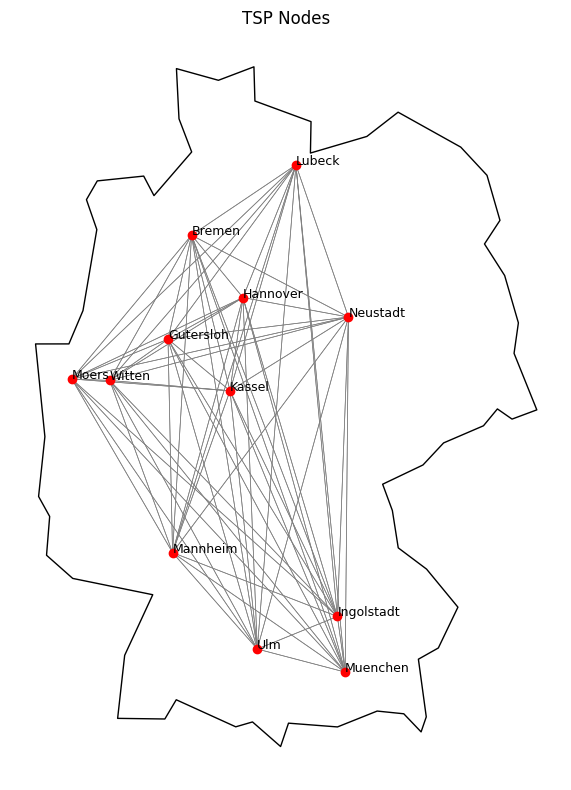

In [ ]:
with open("tsp.json") as fp:
    city_data = json.load(fp)

city_df = pd.json_normalize(city_data)
city_df = city_df.sample(n=12, random_state=200)  # only 12 cities

dist_mat = euclidean_distance_matrix(
    city_df[["row.latitude", "row.longitude"]].to_numpy()
)
dist_df = pd.DataFrame(dist_mat, index=city_df["row.city"], columns=city_df["row.city"])
distance_df = dist_df.reset_index().melt(
    id_vars="row.city", var_name="to.city", value_name="distance"
)

fig, ax = plt.subplots(figsize=(20, 8))
COUNTRY.plot(ax=ax, color="white", edgecolor="black")

ax.scatter(city_df["row.longitude"], city_df["row.latitude"], color="red", zorder=3)

for _, row in city_df.iterrows():
    ax.text(
        row["row.longitude"], row["row.latitude"], row["row.city"], fontsize=9, zorder=4
    )

for idx, row1 in city_df.iterrows():
    for jdx, row2 in city_df.iterrows():
        if idx != jdx:
            ax.plot(
                [row1["row.longitude"], row2["row.longitude"]],
                [row1["row.latitude"], row2["row.latitude"]],
                color="grey",
                linewidth=0.5,
                zorder=2,
            )


ax.set_title("TSP Nodes")
ax.axis("off")
plt.tight_layout()
plt.show()

## Model Definition


#### Sets and Parameters
We start with defining the 
container for our model. We then define a set (`ii`) of cities and  a 2-dimensional parameter (`c`) that containes the distance matrix.

In [4]:
m = Container()

# SETS
ii = Set(m, name="ii", domain="*", records=city_df["row.city"])
i = Set(m, "i", domain=ii)

# ALIASES
jj = Alias(m, "jj", alias_with=ii)
j = Alias(m, "j", alias_with=i)

# PARAMETER
c = Parameter(m, "c", domain=[ii, jj], records=distance_df)

#### Variables
Next, we define a binary variable, `x` that represents the leg of trip. It is `1`, if the salesman travels from city `ii` to city `jj` and `0` otherwise.

In [5]:
# VARIABLES
x = Variable(
    m,
    name="x",
    type="binary",
    domain=[ii, jj],
    description="decision variables - leg of trip",
)

#### Equations
We then define two constraints that control the number of times a city is entered and left, which must be exactly once.

In [6]:
# EQUATIONS
rowsum = Equation(m, name="rowsum", domain=ii, description="leave each city only once")
colsum = Equation(
    m,
    name="colsum",
    domain=jj,
    description="arrive at each city only once",
)

rowsum[i] = Sum(j, x[i, j]) == 1
colsum[j] = Sum(i, x[i, j]) == 1

#### Objective Function
Our objective is to minimize the total distance traveled.

In [7]:
objective = Sum([i, j], c[i, j] * x[i, j])

To prevent a tour from looping within a single city, we must ensure no travel occurs from a city to itself. Therefore, we fix the decision variable (`x`) representing a path from any city `ii` to itself to `0`. Finally, we consolidate everything into a model.

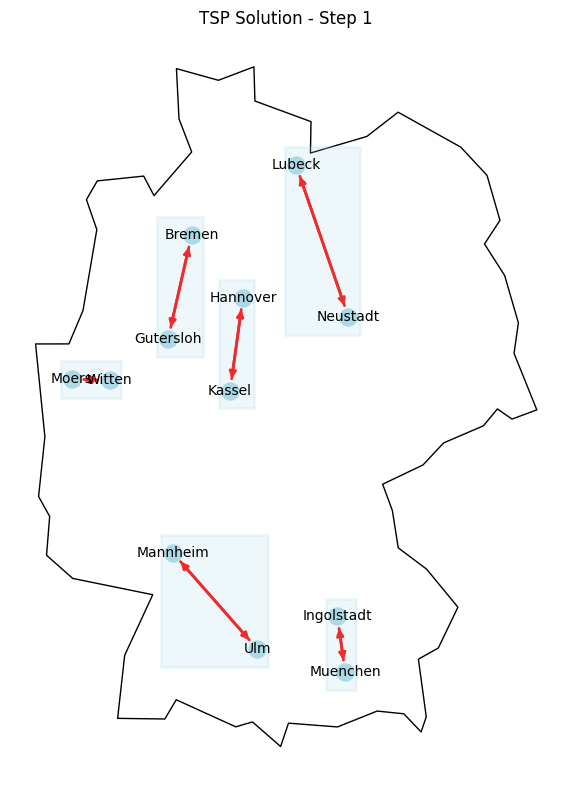

In [8]:
# exclude diagonal
x.fx[ii, ii] = 0

# SETS
i.setRecords(city_df["row.city"])

# options. Make sure MIP solver finds global optima.
assign = Model(
    m,
    name="assign",
    equations=[rowsum, colsum],
    problem="mip",
    sense="min",
    objective=objective,
)
assign.solve(options=Options(relative_optimality_gap=0))

# PLOTTING THE SOLUTION
G_sub = nx.DiGraph()
G_sub.add_nodes_from(m['i'].getUELs())
x_filtered = x.records[x.records['level'] > 0.5].loc[:, :"level"]
edges =  list(zip(x_filtered['ii'], x_filtered['jj']))
G_sub.add_edges_from(edges)

S = [G_sub.subgraph(c).copy() for c in nx.strongly_connected_components(G_sub)]
plot_solution(G_sub.edges(), 0, m['i'].getUELs(), city_df, S)

The plot shows a common problem when solving the Traveling Salesman Problem: the formation of multiple subtours instead of a single, complete tour. One of the most effective ways to tackle this issue is with the **Dantzig-Fulkerson-Johnson** (DFJ) formulation. It's an exact method, meaning it systematically eliminates subtours to guarantee finding the global optimal solution.

### Subtour Elimination

The **DFJ** method prevents the formation of subtours by adding constraints that require any proper subset of cities to have at least two edges connecting to cities outside the subset. This ensures the tour is fully connected.

Since there is an exponential number of these potential subtour elimination constraints, they aren't all added at once. Instead, the problem is typically solved iteratively using a cutting-plane method: an initial solution is found, and if it contains subtours, new constraints ("cuts") are added specifically to eliminate those subtours. This process is repeated until the solution is a single, complete tour.


In order to implement the same, we first define some sets and paramete to keep track of the cuts. The main equation, `cut`, is added to the model which will add new cuts in every iteration.

In [9]:
# Set
cc = Set(m, name="cc", records=[f"c{c}" for c in range(1, 1001)])

# Alias
ccc = Alias(m, name="ccc", alias_with=cc)  # we allow up to 1000 cuts

# Set
curcut = Set(
    m,
    name="curcut",
    domain=cc,
    description="current cut always one element",
)
allcuts = Set(m, name="allcuts", domain=cc, description="total cuts")

# Parameter
cutcoeff = Parameter(m, name="cutcoeff", domain=[cc, i, j])

# Equation
cut = Equation(m, name="cut", domain=cc, description="dynamic cuts")

cut[allcuts] = (
    Sum([i, j], cutcoeff[allcuts, i, j] * x[i, j]) >= 1
)

tspcut = Model(
    m,
    name="tspcut",
    equations=[rowsum, colsum, cut],
    problem="mip",
    sense="MIN",
    objective=objective,
)

The following cell, iteratively solve the extended tsp model (`tspcut`) and adds new cuts whenever a subtour is detected until only one tour is remaining.

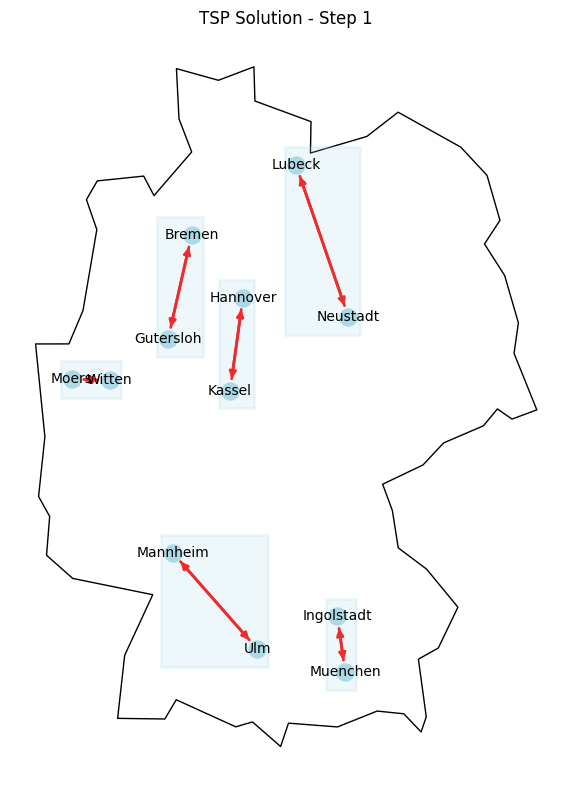

Cut: c1		 # of subtours remaining: 5


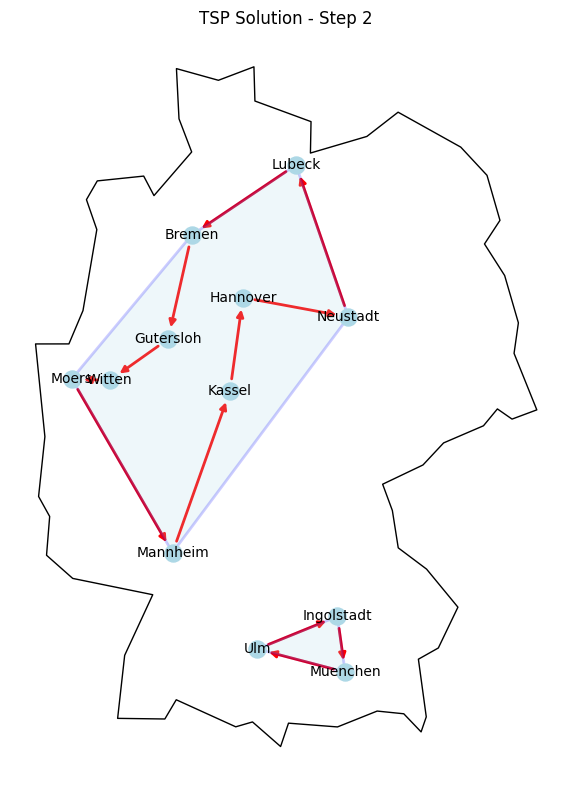

Cut: c2		 # of subtours remaining: 1


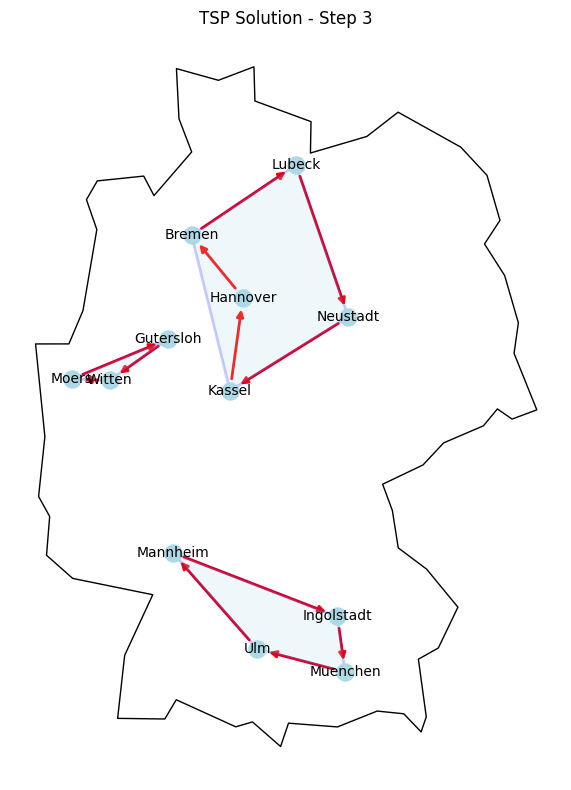

Cut: c3		 # of subtours remaining: 2


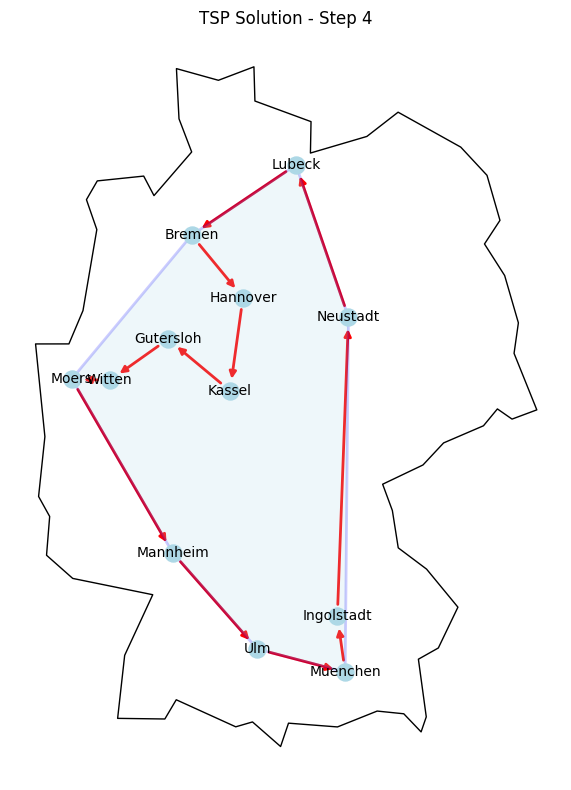

No subtours remaining. Solution found!!
Total Distance traveled:  19.5235


In [10]:
curcut[cc].where[Ord(cc) == 1] = True
cut_count = 0
for ccc_loop in ccc.toList():
    G_sub = nx.DiGraph()
    G_sub.add_nodes_from(m["i"].getUELs())
    x_filtered = x.records[x.records["level"] > 0.5].loc[:, :"level"]
    edges = list(zip(x_filtered["ii"], x_filtered["jj"]))
    G_sub.add_edges_from(edges)
    S = [G_sub.subgraph(c).copy() for c in nx.strongly_connected_components(G_sub)]
    plot_solution(G_sub.edges(), cut_count, m["i"].getUELs(), city_df, S)
    cut_count = cut_count + 1
    num_subtours = len(S)
    if num_subtours == 1:  # done: no subtours
        break

    nodes_all = set(m["i"].getUELs())
    for s in S:
        nodes_s = set(s.nodes())
        nodes_sp = nodes_all - nodes_s

        for i in nodes_s:
            for j in nodes_sp:
                cutcoeff[curcut, i, j] = 1

        allcuts[curcut] = True  # include this cut in set
        curcut[cc] = curcut[cc - 1]

    tspcut.solve(options=Options())

    print(f"Cut: {ccc_loop}\t\t # of subtours remaining: {num_subtours - 1}")

print("No subtours remaining. Solution found!!")
print(f"Total Distance traveled: {tspcut.objective_value: .4f}")